In [1]:
from src import data
from src import mlp

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

### Process Wave Data

In [2]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

In [3]:
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

station46240specs = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

In [4]:
# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data_46240 = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data_46240.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

In [5]:
all_wave_data_46240.shape

(116706, 9)

In [6]:
all_wave_data_46240[all_wave_data_46240.isnull().any(axis=1)]

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-04-06 23:00:00,2009,4,6,23,0.96,15.38,11.37,7.0,NaN
2009-04-07 00:00:00,2009,4,7,0,0.83,11.76,10.87,354.0,NaN
2009-04-08 01:00:00,2009,4,8,1,0.87,12.50,10.72,352.0,NaN
2009-04-08 02:00:00,2009,4,8,2,0.88,11.76,10.62,347.0,NaN
2009-04-08 03:00:00,2009,4,8,3,0.75,11.76,10.31,349.0,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,2022,8,31,8,0.20,NaN,5.65,NaN,15.7
2022-08-31 09:00:00,2022,8,31,9,0.21,NaN,5.84,NaN,15.6
2022-08-31 10:00:00,2022,8,31,10,0.23,NaN,5.85,NaN,15.6


In [7]:
# drop rows that contain NaN values
all_wave_data_46240.dropna(inplace=True)

In [8]:
wvht_scaler = StandardScaler()
all_wave_data_46240['WVHT'] = wvht_scaler.fit_transform(all_wave_data_46240[['WVHT']])

In [9]:
# normalize the input data since our features are on different scales / units
columns_to_normalize = ['DPD', 'APD', 'MWD', 'WTMP']
scaler_other = StandardScaler()
all_wave_data_46240[columns_to_normalize] = scaler_other.fit_transform(all_wave_data_46240[columns_to_normalize])

In [10]:
all_wave_data_46240.head()

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,0.385981,0.083302,-0.002309,0.326864,-1.218022
2009-01-01 01:00:00,2009,1,1,1,0.154898,-0.371289,-0.860774,0.246659,-1.218022
2009-01-01 02:00:00,2009,1,1,2,0.270439,-0.156929,-1.236353,0.326864,-1.218022
2009-01-01 03:00:00,2009,1,1,3,0.432197,0.083302,-1.338295,0.326864,-1.218022
2009-01-01 04:00:00,2009,1,1,4,0.108682,0.663551,-1.214891,0.420437,-1.218022


### Splitting Data

In [11]:
train_df = all_wave_data_46240[all_wave_data_46240.index.year <= 2018]
val_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2019) | (all_wave_data_46240.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2021) | (all_wave_data_46240.index.year == 2022)]

In [12]:
missing_indices_train = data.check_for_missing_rows(train_df)
len(missing_indices_train)

614

In [13]:
missing_indices_val = data.check_for_missing_rows(val_df)
len(missing_indices_val)

49

In [14]:
missing_indices_test = data.check_for_missing_rows(test_df)
len(missing_indices_test)

16

### Training Baseline MLP Models

Adding a simple helper function for plotting to clean up the notebook.

In [15]:
def plot_predicted_vs_actual(model, X_val, y_val, scaler, N=1000):
    model.eval()

    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val).float()
        y_val_tensor = torch.tensor(y_val).float()
        
        predictions = model(X_val_tensor)

        # Convert predictions and actual values to numpy arrays
        predictions_np = predictions.numpy().reshape(-1, 1)  # Reshape for scaler
        y_val_np = y_val_tensor.numpy().reshape(-1, 1)       # Reshape for scaler
        
        # Unscale predictions and actual values
        predictions_unscaled = scaler.inverse_transform(predictions_np).flatten()
        y_val_unscaled = scaler.inverse_transform(y_val_np).flatten()
        
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled[:N], label='Actual')
    plt.plot(predictions_unscaled[:N], label='Predicted')
    plt.title('Actual vs Predicted Values (Unscaled)')
    plt.xlabel('Sample index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

#### MLP 1

We use the following paramters for building our dataset:
- window = 12
- step = 12
- lead = 12

We use the follow hyperparamters for model training:
- learning rate: 1e-4
- epochs: 50

In [16]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=12,
                                                          step=12,
                                                          lead=12)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76951, 60) y_train shape: (76951,)


In [17]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=12,
                                                      step=12,
                                                      lead=12)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (16043, 60) y_val shape: (16043,)


In [18]:
model = mlp.WaveForecastMLP(input_dim=12*5)

train_loader = mlp.build_dataloader_from_np(X_train, y_train, batch_size=64, shuffle=False)
val_laoder = mlp.build_dataloader_from_np(X_val, y_val, batch_size=64, shuffle=False)

criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # added in weight regularization

mlp.train(model=model,
          train_loader=train_loader,
          val_loader=val_laoder,
          criterion=criterion,
          optimizer=optimizer,
          n_epochs=50)

Epoch: 1/50 - Train Loss: 0.7269 - Val Loss: 0.4284
Epoch: 10/50 - Train Loss: 0.3737 - Val Loss: 0.3525


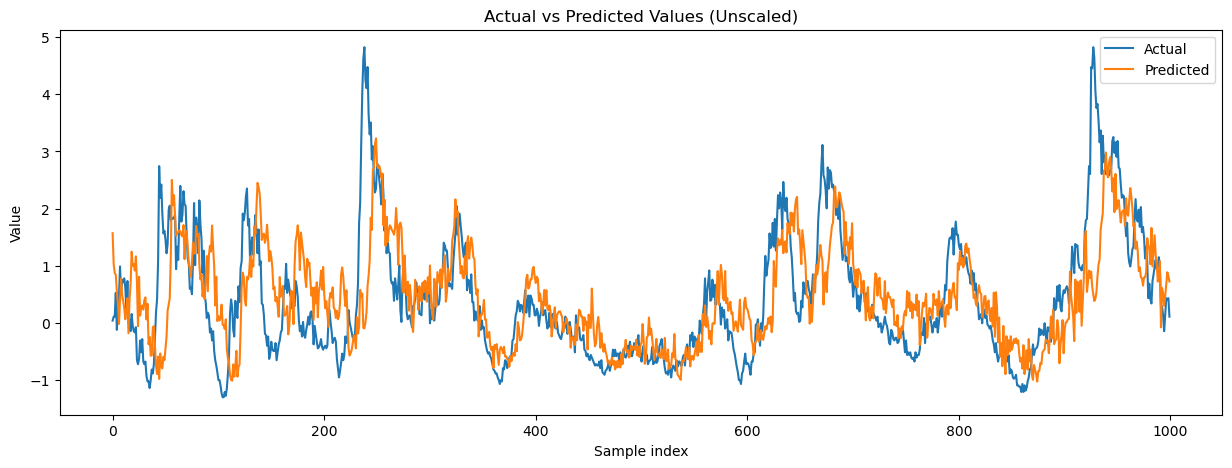

In [66]:

plot_predicted_vs_actual(model, X_val, y_val, scaler=wvht_scaler, N=1000)

#### MLP 2

We use the following paramters for building our dataset:
- window = 24
- step = 4
- lead = 12

We use the follow hyperparamters for model training:
- learning rate: 1e-4
- weight decay: 1e-5
- epochs: 50

From MLP 1, we noticed some slight overfitting on the training set, so we added weight decay to out optimizer. We also increased the window (number of hourly measurements) to 24 that are spaced 6 hour apart instead of 4.

In [43]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=24,
                                                          step = 4,
                                                          lead=12)


print(f'X_train shape: {X_train.shape} y_val shape: {y_train.shape}')

X_train shape: (72083, 120) y_val shape: (72083,)


In [44]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=24,
                                                      step=4,
                                                      lead=12)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (15719, 120) y_val shape: (15719,)


Epoch: 1/50 - Train Loss: 1.5145 - Val Loss: 0.4374
Epoch: 10/50 - Train Loss: 0.1701 - Val Loss: 0.2137
Epoch: 20/50 - Train Loss: 0.1649 - Val Loss: 0.1651
Epoch: 30/50 - Train Loss: 0.1436 - Val Loss: 0.1384
Epoch: 40/50 - Train Loss: 0.1287 - Val Loss: 0.1180
Epoch: 50/50 - Train Loss: 0.1209 - Val Loss: 0.1174


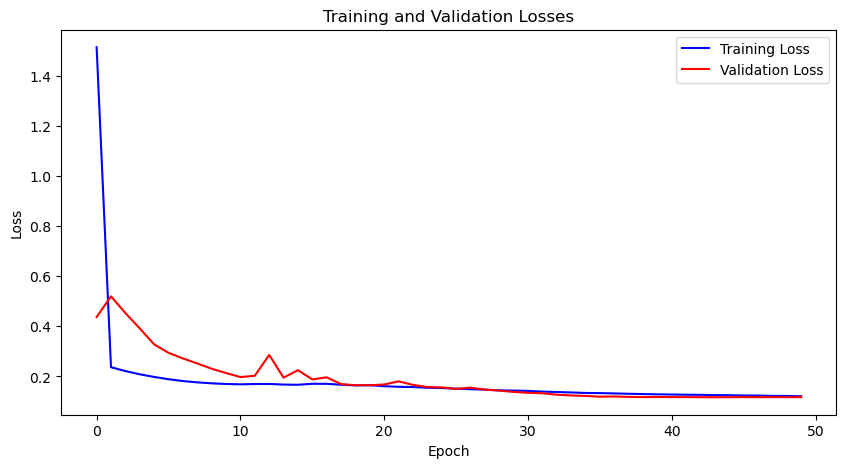

In [45]:
model = mlp.WaveForecastMLP(input_dim=24*5)

train_loader = mlp.build_dataloader_from_np(X_train, y_train, batch_size=64, shuffle=False)
val_laoder = mlp.build_dataloader_from_np(X_val, y_val, batch_size=64, shuffle=False)

criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # added in weight regularization

mlp.train(model=model,
          train_loader=train_loader,
          val_loader=val_laoder,
          criterion=criterion,
          optimizer=optimizer,
          n_epochs=50)

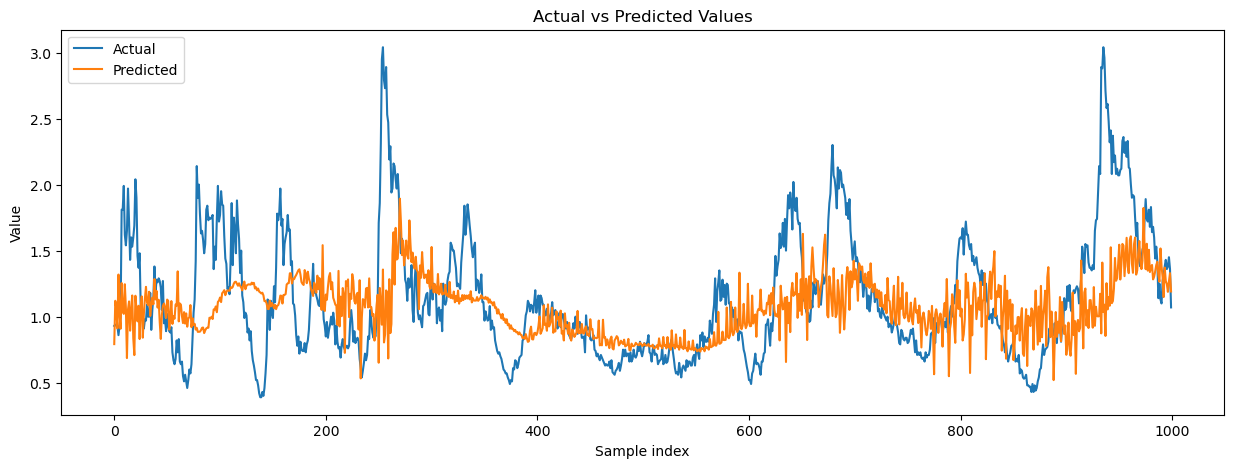

In [46]:
plot_predicted_vs_actual(model, X_val, y_val, N=1000)